### Project

### Importing important Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [2]:
from pathlib import Path
import random
from timeit import default_timer as timer
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Importing Datasets

In [4]:
image_path = Path("data/")
image_path = image_path / "new-plant-diseases-dataset"
train_dir = image_path /"New Plant Diseases Dataset(Augmented)"/"train"
valid_dir = image_path /"New Plant Diseases Dataset(Augmented)"/"valid"
test_dir = image_path /"test"

if train_dir.is_dir() and valid_dir.is_dir() and test_dir.is_dir():
    print(f'Target directory is present at {train_dir}')
    print(f'Validictory directory is present at {valid_dir}')
    print(f'Test directory is present at {test_dir}')
else:
    print(" Few directories are missing, check your folders")

Target directory is present at data\new-plant-diseases-dataset\New Plant Diseases Dataset(Augmented)\train
Validictory directory is present at data\new-plant-diseases-dataset\New Plant Diseases Dataset(Augmented)\valid
Test directory is present at data\new-plant-diseases-dataset\test


Let's Look into a random image dimensions

Soybean___healthy
 Image Size: (256, 256) | Image mode: RGB


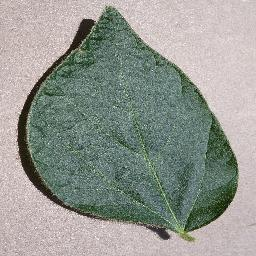

In [5]:
# random.seed(24)

# Getting all image paths
image_path_list = list(image_path.glob("*/*/*/*.jpg"))

# Picking a random Image path
random_image_path = random.choice(image_path_list)
# random_image_path

# Getting image class
image_class = random_image_path.parent.stem
print(image_class)

# Opening the image
image = Image.open(random_image_path)
print(f' Image Size: {image.size} | Image mode: {image.mode}')
image

### Transforming the data

In [6]:
data_transform = transforms.Compose([
    transforms.Resize(size = (256,256)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

### Loading Image

In [7]:
train_data = ImageFolder(root=train_dir,
                         transform=data_transform,
                         target_transform=None)

valid_data = ImageFolder(root=valid_dir,
                         transform=data_transform,
                         target_transform=None)
test_data = ImageFolder(root= test_dir,
                        transform=test_transform)
train_data,valid_data, test_data

(Dataset ImageFolder
     Number of datapoints: 70295
     Root location: data\new-plant-diseases-dataset\New Plant Diseases Dataset(Augmented)\train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 17572
     Root location: data\new-plant-diseases-dataset\New Plant Diseases Dataset(Augmented)\valid
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 33
     Root location: data\new-plant-diseases-dataset\test
     Stand

In [8]:
class_name = train_data.classes
class_name

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [9]:
img,label = train_data[0]
img.shape,label, img.min(), img.max()

(torch.Size([3, 256, 256]), 0, tensor(0.), tensor(0.8745))

### DataLoader

In [10]:
BATCH_SIZE = 32
NUM_OF_WORKERS = os.cpu_count() if os.cpu_count() else 0
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_OF_WORKERS,
                              shuffle= True)
valid_dataloader = DataLoader(dataset= valid_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_OF_WORKERS,
                              shuffle=False)
test_dataloader = DataLoader(dataset= test_data,
                             batch_size= BATCH_SIZE,
                             num_workers= NUM_OF_WORKERS,
                             shuffle=False)

In [11]:
NUM_OF_WORKERS

16

### Creating the CNN Model

In [12]:
class CNNModel(nn.Module):
    def __init__(self, 
                 input_units: int, 
                 hidden_units: int,
                 output_units: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_units, out_channels= hidden_units, kernel_size=3, stride= 1, padding= 2),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size= 3, stride=1, padding= 2),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units*2, kernel_size=3, stride= 1, padding= 3),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels= hidden_units*2, kernel_size= 3, stride=1, padding= 3),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels= hidden_units*3, kernel_size=3, stride= 1, padding= 1),
            nn.BatchNorm2d(hidden_units*3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*3, out_channels= hidden_units*3, kernel_size= 3, stride=1, padding= 1),
            nn.BatchNorm2d(hidden_units*3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*3, out_channels= hidden_units*4, kernel_size=3, stride= 1, padding= 1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*4, out_channels= hidden_units*4, kernel_size= 3, stride=1, padding= 1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, out_channels= hidden_units*5, kernel_size=3, stride= 1, padding= 1),
            nn.BatchNorm2d(hidden_units*5),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*5, out_channels= hidden_units*5, kernel_size= 3, stride=1, padding= 1),
            nn.BatchNorm2d(hidden_units*5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_6 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*5, out_channels= hidden_units*6, kernel_size=3, stride= 1, padding= 1),
            nn.BatchNorm2d(hidden_units*6),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*6, out_channels= hidden_units*6, kernel_size= 3, stride=1, padding= 1),
            nn.BatchNorm2d(hidden_units*6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_7 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*6, out_channels= hidden_units*7, kernel_size=3, stride= 1, padding= 1),
            nn.BatchNorm2d(hidden_units*7),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*7, out_channels= hidden_units*7, kernel_size= 3, stride=1, padding= 1),
            nn.BatchNorm2d(hidden_units*7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_8 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*7, out_channels= hidden_units*8, kernel_size=3, stride= 1, padding= 1),
            nn.BatchNorm2d(hidden_units*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*8, out_channels= hidden_units*8, kernel_size= 3, stride=1, padding= 1),
            nn.BatchNorm2d(hidden_units*8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8,out_features=output_units)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.classifier(self.conv_block_8(self.conv_block_7(self.conv_block_6(self.conv_block_5(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))))))) # benefits from operator fusion
        

In [13]:
torch.manual_seed(42)
model_0 = CNNModel(input_units=3,
                   hidden_units=20,
                   output_units=len(class_name)).to(device)
model_0

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (

In [14]:
model_0(img.unsqueeze(dim=0).to(device))

tensor([[ 1.1498, -0.5437,  0.1414, -1.1253,  0.3245, -0.4739,  0.6518,  0.3190,
         -0.5242, -1.2336, -0.8664, -0.2593,  1.0153, -1.7952,  0.3155,  0.0611,
         -0.1642, -0.6012, -0.0244, -0.1215,  0.6298, -0.3841,  0.7614,  0.5999,
         -0.6880,  0.7908,  0.3062,  0.7461, -0.2415,  1.5508,  0.5982, -0.4558,
          1.9926, -0.0840,  0.4310,  0.8841, -0.2722, -0.4827]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

### Creating Training and Testing Loop

In [15]:
# Creating a train_step() function
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = "cpu") -> float:
    """
    Trains the model for one epoch on the given dataloader.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (DataLoader): The dataloader to train on.
        loss_fn (nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        device (str): The device to train on ("cpu" or "cuda").
        
    Returns:
        float: The average loss for the epoch.
    """
    model.train()  # Set the model to training mode

    # Setting up the train loss and accuracy values
    train_loss = 0.0
    train_acc = 0.0
    correct =0
    total =0

    # Looping through the dataloader 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move data to the specified device
        
        # Forward pass
        y_pred = model(X)
        
        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate loss
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        # Calculating the accuracy metrics
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # Get the predicted class indices
        correct += (y_pred_class == y).sum().item()
        total += y.size(0)
        # train_acc += (y_pred_class == y).sum().item() / len(y_pred)  # Calculating the accuracy for the batch
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = correct / total
    return train_loss, train_acc

In [16]:
# Creating a valid_step() function
def valid_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: str) -> tuple[float, float]:
    """
    Evaluates the model on the given dataloader.
    Args:
        model (nn.Module): The model to evaluate.
        dataloader (DataLoader): The dataloader to evaluate on.
        loss_fn (nn.Module): The loss function to use.
        device (str): The device to evaluate on ("cpu" or "cuda").
    Returns:
        Tuple[float, float]: The average loss and accuracy for the epoch.
    """

    # Putting the model in evaluation mode
    model.eval()

    # Setup the test loss and accuracy values
    valid_loss = 0.0
    valid_acc = 0.0

    # Turn on inference mode
    with torch.inference_mode():
        # Looping through the dataloader
        for batch, (X, y) in enumerate(dataloader):

            # Move data to the specified device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            valid_loss += loss.item()  # Accumulate loss

            # Calculating the accuracy metrics
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            valid_acc += (y_pred_class == y).sum().item() / len(y_pred)
    # Adjust metrics to get average loss and accuracy per batch
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)
    return valid_loss, valid_acc


### Creating a train() function to combine train_step() and test_step()

In [32]:
from tqdm.auto import tqdm

# 1. Creating a 'train()' function to combine 'train_step()' and 'test_step()'
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device= device,
          train_val =True) -> None:
    """
    Trains and evaluates the model for a given number of epochs.
    
    Args:
        model (nn.Module): The model to train and evaluate.
        train_dataloader (DataLoader): The dataloader for training data.
        valid_dataloader (DataLoader): The dataloader for validating data.
        loss_fn (nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        epochs (int): Number of epochs to train for.
        device (str): Device to run the training on ("cpu" or "cuda").
    """

    # Creating an empty results dictionary to store training and validating results
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }

    # Looping through the number of epochs
    if train_val == True:
        print("It's training and evaluating")
            
        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            # Training step
            train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
            
            # Testing step
            valid_loss, valid_acc = valid_step(model=model,
                                            dataloader=valid_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)
                
            # Print out the results
            print(f"Epoch: {epoch+1}/{epochs}, "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"valid Loss: {valid_loss:.4f}, valid Acc: {valid_acc:.4f}")
            
            # Updating the results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["valid_loss"].append(valid_loss)
            results["valid_acc"].append(valid_acc)
        
    else:
        print("It's just evaluating")
        for epoch in tqdm(range(epochs), desc="Evaluating Epochs"):
            # Testing step
            valid_loss, valid_acc = valid_step(model=model,
                                            dataloader=valid_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)
                
            # Print out the results
            print(f"Epoch: {epoch+1}/{epochs}, "
                f"valid Loss: {valid_loss:.4f}, valid Acc: {valid_acc:.4f}")
            
            # Updating the results dictionary
            results["train_loss"].append(0)
            results["train_acc"].append(0)
            results["valid_loss"].append(valid_loss)
            results["valid_acc"].append(valid_acc)

    # Return the results dictionary with training and validating results
    return results

Loss and Optimization functions

In [18]:
loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss is commonly used for multi-class classification tasks
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)  # Using Adam optimizer with a learning rate of 0.001

### Training and Evaluating the Model

In [19]:
#Starting the timer
from timeit import default_timer as timer
start_time = timer()

model_save_path = Path('models') / 'Plant_Disease_CNN.pth'

if model_save_path.exists():
    print(f'The Model is already trained and saved to {model_save_path}...')
    print('Loading the model from the saved directory')
    model_0 = CNNModel(input_units=3,
                       hidden_units=20,
                       output_units=len(class_name)).to(device)
    model_0.load_state_dict(torch.load(f=model_save_path))
    model_0.to(device)

    model_0_results = train(model=model_0,
                            train_dataloader=train_dataloader,
                            valid_dataloader=valid_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device,
                            train_val= False)

else:
    print("Training and Evaluating the model")
    # Training and evaluating the model
    model_0_results = train(model=model_0,
                            train_dataloader=train_dataloader,
                            valid_dataloader=valid_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device)
    
    # Saving the model
    # Creating a directory to save the model
    MODEL_PATH = Path('models')
    MODEL_PATH.mkdir(parents=True,
                    exist_ok=True)  # Create the directory if it doesn't exist

    # Creating model save
    MODEL_NAME = 'Plant_Disease_CNN.pth'
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # Saving the model state dictionary
    print(f'Saving model to: {MODEL_SAVE_PATH}')
    torch.save(obj=model_0.state_dict(),
            f=MODEL_SAVE_PATH)

# Ending the timer
end_time = timer()
# Calculating the total training time
total_training_time = end_time - start_time

print(f"Total training time: {total_training_time:.2f} seconds")

The Model is already trained and saved to models\Plant_Disease_CNN.pth...
Loading the model from the saved directory
It's just evaluating


Evaluating Epochs:  10%|█         | 1/10 [04:43<42:32, 283.66s/it]

Epoch: 1/10, valid Loss: 0.2272, valid Acc: 0.9268


Evaluating Epochs:  20%|██        | 2/10 [09:22<37:26, 280.75s/it]

Epoch: 2/10, valid Loss: 0.2322, valid Acc: 0.9253


Evaluating Epochs:  30%|███       | 3/10 [13:59<32:33, 279.03s/it]

Epoch: 3/10, valid Loss: 0.2263, valid Acc: 0.9281


Evaluating Epochs:  40%|████      | 4/10 [18:38<27:54, 279.11s/it]

Epoch: 4/10, valid Loss: 0.2271, valid Acc: 0.9249


Evaluating Epochs:  50%|█████     | 5/10 [22:31<21:53, 262.62s/it]

Epoch: 5/10, valid Loss: 0.2183, valid Acc: 0.9277


Evaluating Epochs:  60%|██████    | 6/10 [24:51<14:43, 220.92s/it]

Epoch: 6/10, valid Loss: 0.2113, valid Acc: 0.9314


Evaluating Epochs:  70%|███████   | 7/10 [27:11<09:42, 194.30s/it]

Epoch: 7/10, valid Loss: 0.2301, valid Acc: 0.9250


Evaluating Epochs:  80%|████████  | 8/10 [30:26<06:29, 194.66s/it]

Epoch: 8/10, valid Loss: 0.2263, valid Acc: 0.9268


Evaluating Epochs:  90%|█████████ | 9/10 [31:51<02:40, 160.17s/it]

Epoch: 9/10, valid Loss: 0.2259, valid Acc: 0.9269


Evaluating Epochs: 100%|██████████| 10/10 [33:15<00:00, 199.57s/it]

Epoch: 10/10, valid Loss: 0.2236, valid Acc: 0.9285
Total training time: 1995.81 seconds


In [20]:
model_0_results

{'train_loss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'train_acc': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'valid_loss': [0.22720934646557328,
  0.2321708900063955,
  0.22625427318551705,
  0.2270748042781435,
  0.21830643645201647,
  0.21131799575284027,
  0.23013342078510587,
  0.22634922833659485,
  0.22592551659316418,
  0.2236029078870144],
 'valid_acc': [0.9268181818181818,
  0.925340909090909,
  0.928125,
  0.9249431818181818,
  0.9277272727272727,
  0.9314204545454545,
  0.925,
  0.9268181818181818,
  0.926875,
  0.9285227272727272]}

In [21]:
class_name[torch.argmax(torch.softmax(model_0(img.unsqueeze(dim=0).to(device)),dim=1),dim=1)], class_name[label]

('Apple___Apple_scab', 'Apple___Apple_scab')

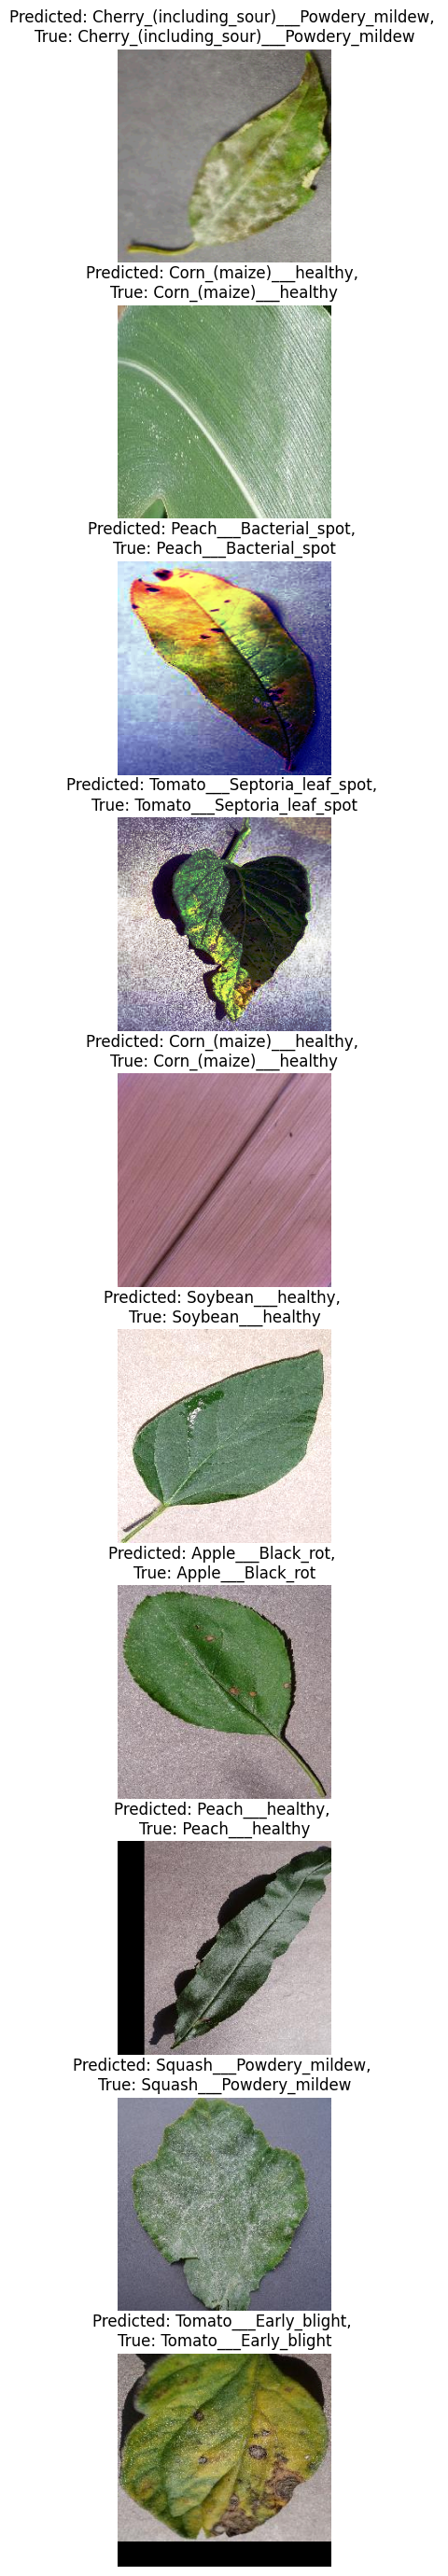

In [22]:
index = random.sample(range(len(train_data)),k =10)
plt.figure(figsize=(10,35))
for i in range(10):
    img,label = train_data[index[i]]
    plt.subplot(10,1,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f'Predicted: {class_name[torch.argmax(torch.softmax(model_0(img.unsqueeze(dim=0).to(device)),dim=1),dim=1)]}, \nTrue: {class_name[label]}')
    plt.axis(False)

### Plotting loss and accuracy curves

In [ ]:
def plot_loss_acc_curves(results):

    # Plotting the training and testing loss curves
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plt.plot(results["train_acc"], label="Train Accuracy")
    plt.plot(results["valid_acc"], label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    # Plotting the training and testing loss curves
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["valid_loss"], label="Validation Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
model_0_results["train_loss"], model_0_results["train_acc"]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

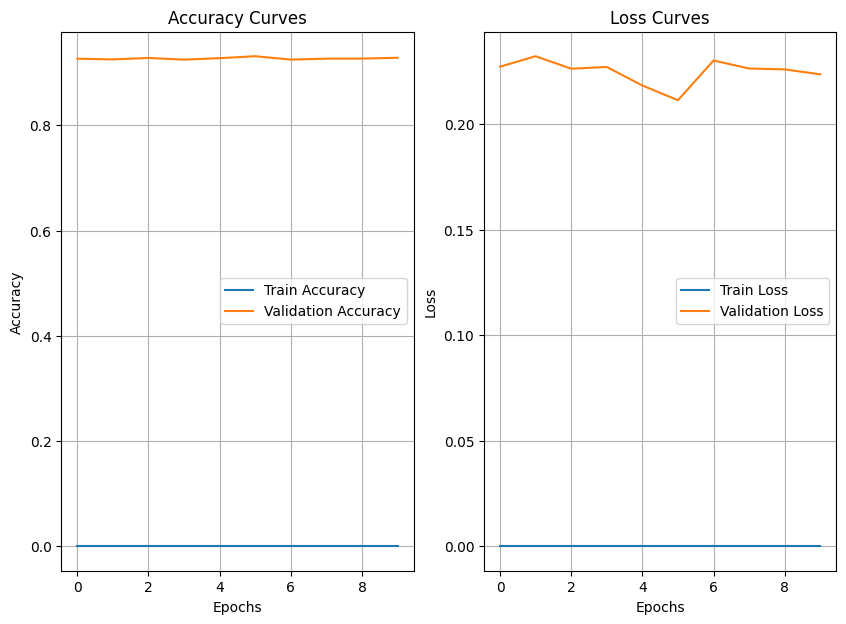

In [41]:
plot_loss_acc_curves(model_0_results)

### Making Confusion Matrix

In [25]:
# Importing tqdm for progress bar
from tqdm.auto import tqdm

#1. Making predictions with our trained model on the validictory dataset
y_preds_valid = []
model_0.eval()
with torch.inference_mode():
    for X,y in tqdm(valid_dataloader, desc="Making predictions on validictory dataset"):
        # Move data to the target device
        X,y = X.to(device),y.to(device)

        # Turning logits into probabilities to the required labels
        y_pred_valid = torch.softmax(model_0(X), dim=1).argmax(dim=1)  # Convert logits to probabilities to required labels

        # Append the predictions to the list
        y_preds_valid.append(y_pred_valid.cpu())

# Concatinating all predictions and turning the list into one tensor
print(y_preds_valid) 
y_preds_valid_tensor = torch.cat(y_preds_valid)

Making predictions on validictory dataset: 100%|██████████| 550/550 [02:19<00:00,  3.93it/s] 


[tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 17,  0,  0,  0,  0,  0, 25,  0,  0]), tensor([ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0]), tensor([25,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 29,  0]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

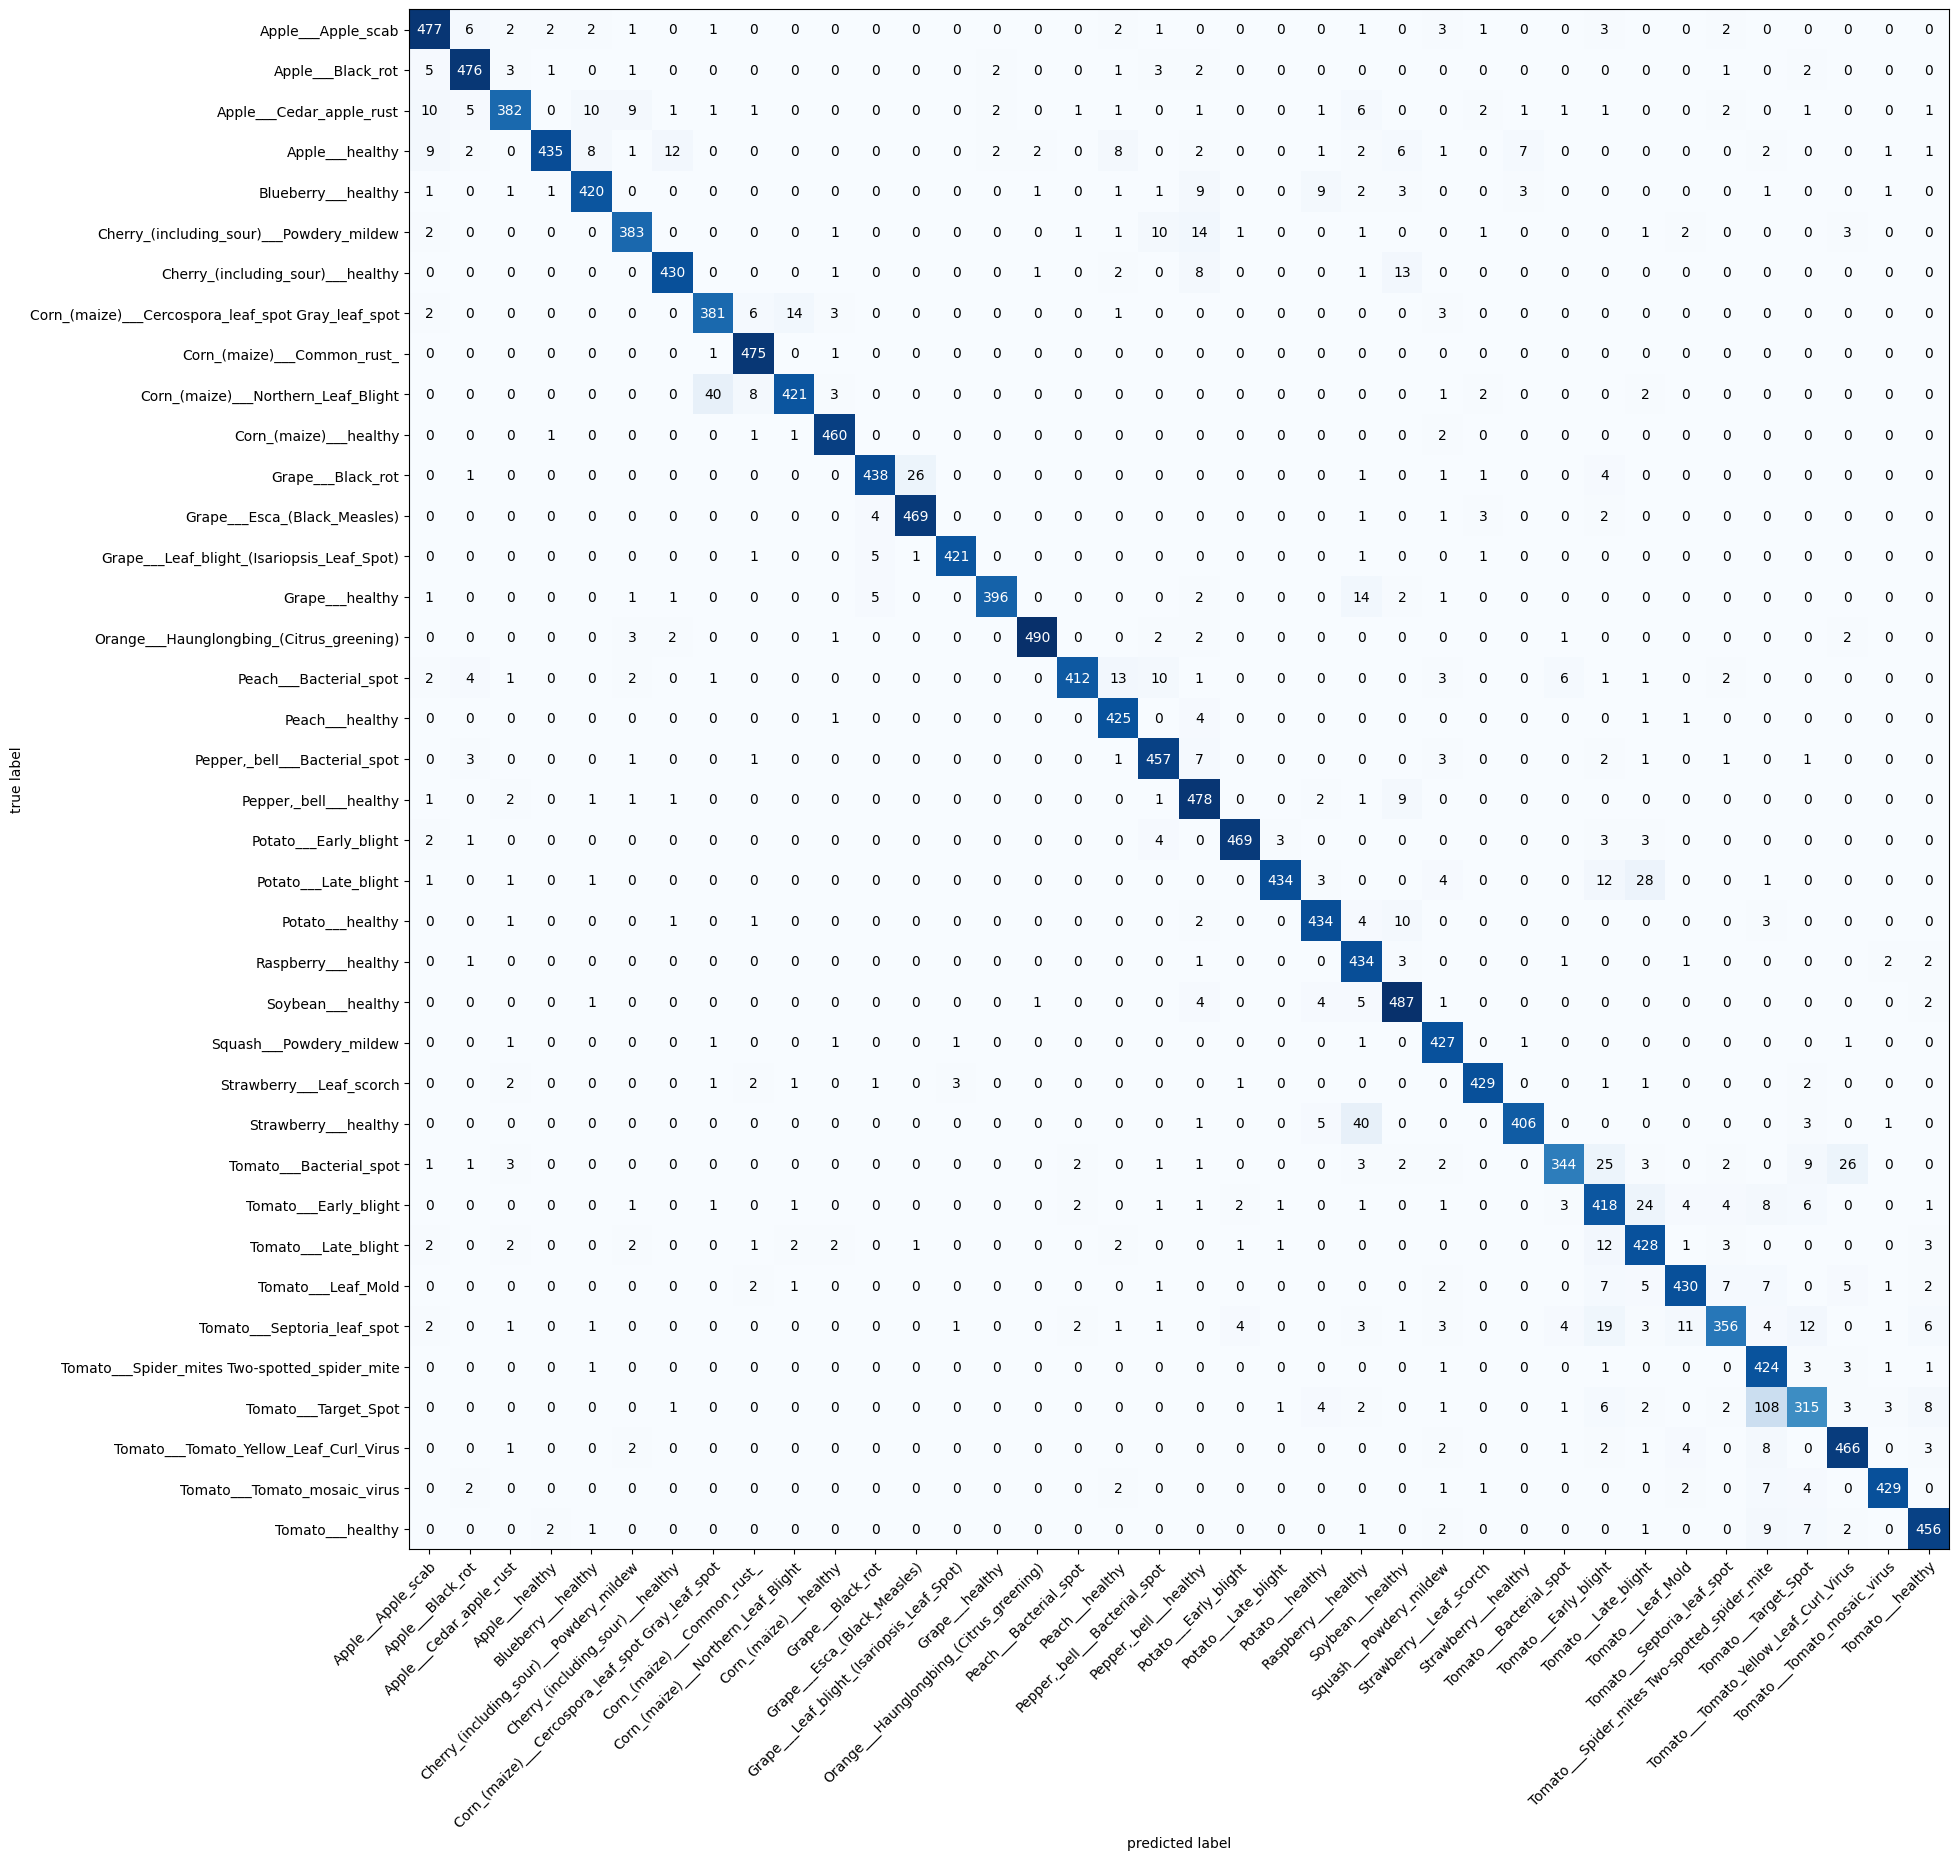

In [26]:
confusion_matrix = ConfusionMatrix(num_classes=len(class_name),
                                   task='multiclass',
                                   normalize=None).to(device)
confusion_matrix_tensor = confusion_matrix(
    preds=y_preds_valid_tensor.to(device),
    target=torch.tensor(valid_data.targets).to(device)
)

# Plotting the Confusion Matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.cpu().numpy(),
                               class_names=class_name,
                               figsize=(20, 20),
                               cmap="Blues")

### The Loss curve shows that my model is preforming really good.

### Implementing the Model to predict the test images

In [27]:
test_data

Dataset ImageFolder
    Number of datapoints: 33
    Root location: data\new-plant-diseases-dataset\test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [28]:
# Importing tqdm for progress bar
from tqdm.auto import tqdm

#1. Making predictions with our trained model on the test dataset
y_preds = []
model_0.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making predictions on test dataset"):
        # Move data to the target device
        X,y = X.to(device),y.to(device)

        # Turning logits into probabilities to the required labels
        y_pred = torch.softmax(model_0(X), dim=1).argmax(dim=1)  # Convert logits to probabilities to required labels

        # Append the predictions to the list
        y_preds.append(y_pred.cpu())



Making predictions on test dataset: 100%|██████████| 2/2 [00:17<00:00,  8.70s/it]


In [29]:
print('Printing the names of the diseases as predicted')
y_preds_tensor = torch.cat(y_preds)
for idx in y_preds_tensor:
    print(f'\n Predicted name: {class_name[idx]} linked to the index number: {idx}')
    print()


Printing the names of the diseases as predicted

 Predicted name: Apple___Black_rot linked to the index number: 1


 Predicted name: Apple___Cedar_apple_rust linked to the index number: 2


 Predicted name: Apple___Cedar_apple_rust linked to the index number: 2


 Predicted name: Apple___Cedar_apple_rust linked to the index number: 2


 Predicted name: Apple___Apple_scab linked to the index number: 0


 Predicted name: Apple___Apple_scab linked to the index number: 0


 Predicted name: Apple___Apple_scab linked to the index number: 0


 Predicted name: Corn_(maize)___Common_rust_ linked to the index number: 8


 Predicted name: Corn_(maize)___Common_rust_ linked to the index number: 8


 Predicted name: Corn_(maize)___Common_rust_ linked to the index number: 8


 Predicted name: Potato___Early_blight linked to the index number: 20


 Predicted name: Potato___Early_blight linked to the index number: 20


 Predicted name: Potato___Late_blight linked to the index number: 21


 Predicted n

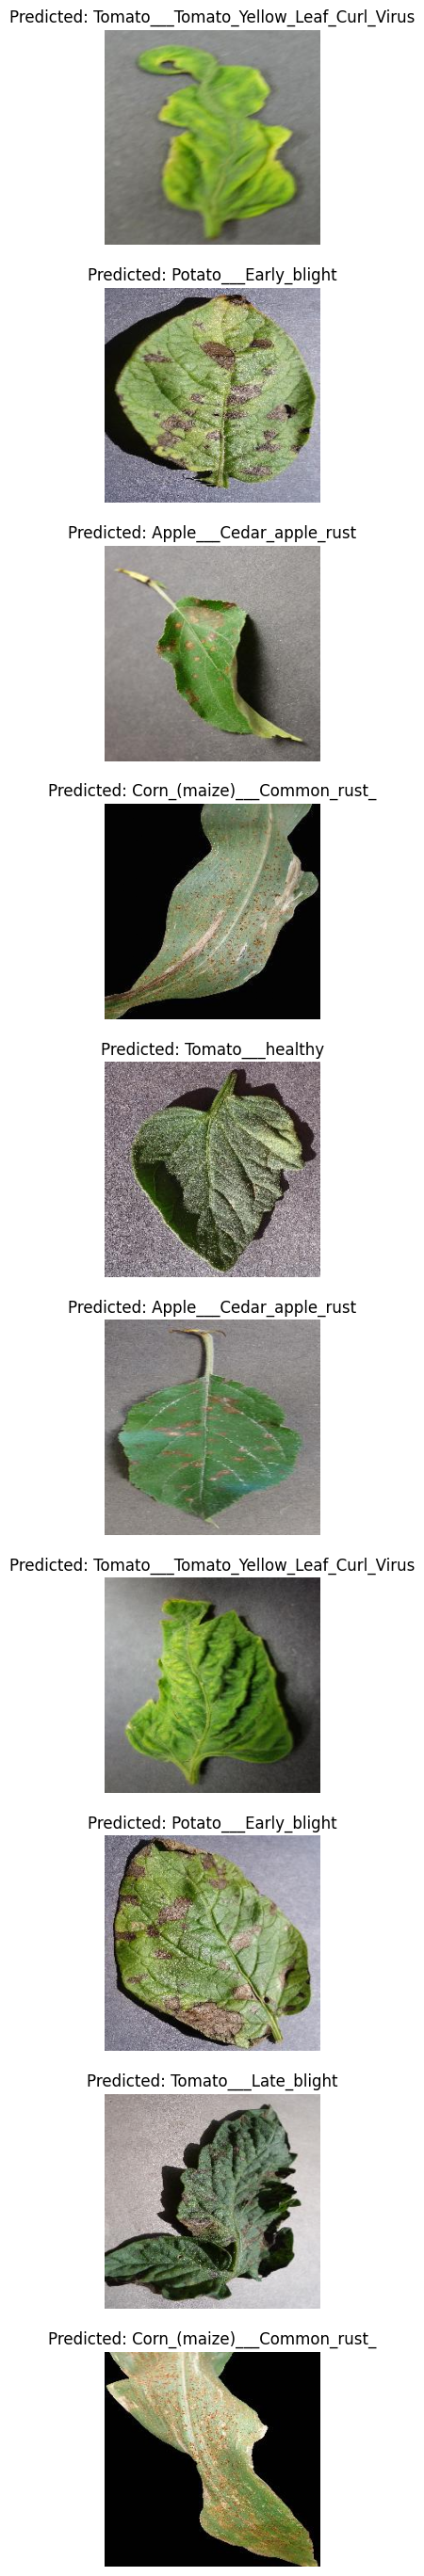

In [30]:
index = random.sample(range(len(test_data)),k =10)
plt.figure(figsize=(10,35))
for i in range(10):
    img,label = test_data[index[i]]
    plt.subplot(10,1,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f'Predicted: {class_name[torch.argmax(torch.softmax(model_0(img.unsqueeze(dim=0).to(device)),dim=1),dim=1)]}')
    plt.axis(False)